In this notebook, we will be working through [Building makemore Part 1: Initialization Batchnorm](https://www.youtube.com/watch?v=P6sfmUTpUmc) by Andrej Karpathy. This is the fourth video in the "Neural Networks: Zero to Hero" series and covers part 1 of it.

The central theme of this video is a deceptively simple question: **does it matter how we initialize our neural network's weights?** The answer turns out to be a resounding _yes_ — bad initialization can cripple training entirely, and the history of deep learning is littered with techniques invented specifically to cope with this problem. We'll build up to two of the most important ideas: **proper weight scaling** (Kaiming/He initialization) and **Batch Normalization**.


# Section 1: Initialization

We briefly touched upon uncharacteristically high losses during the first step of training with a randomly initialized model during the [previous lesson notebook](../lesson_3_makemore_mlp/makemore_mlp.ipynb#why-is-the-initial-loss-so-high?). We will now look into weight initialization further.

**Why initialization matters so much:** In a neural network, the initial weights determine the initial output distribution (predictions), the initial gradient magnitudes, and consequently the trajectory of the entire optimization. Poor initialization leads to:

- **Confidently wrong predictions** at step 0 → enormous initial loss → huge gradients that "waste" early training steps correcting the overconfident output
- **Saturated activations** (e.g. tanh outputs near ±1) → vanishing gradients → slow or stalled learning
- **Exploding activations** → numerical instability → NaN losses

The goal is to find an initialization where the network starts in a "reasonable" state: uniform predictions (not confidently wrong), activations in a useful range, and gradients that flow smoothly through every layer.


In [1]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
# lets copy over some stuff from the previous notebook

# utility to read dataset
DATASET_PATH = '../names.txt'
SPECIAL_TOKEN = "."

def get_dataset():
    with open(DATASET_PATH, 'r') as f:
        rows = [row.strip() for row in f.readlines()]
    return rows

# Load dataset
words = get_dataset()
print(f"{len(words)} names loaded")
print(f"Examples: {words[:8]}")

# Build character mappings — identical to lesson 2
# '.' is our special start/end token at index 0, then a=1, b=2, ..., z=26
all_characters = [SPECIAL_TOKEN] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(all_characters)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")
print(f"Mappings: {itos}")

32033 names loaded
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Vocabulary size: 27
Mappings: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [3]:
def build_dataset(words, block_size=3):
    """
    Convert a list of words into (X, Y) tensors for training.

    X shape: (N, block_size) — each row is a context window of character indices
    Y shape: (N,) — each element is the target character index

    This function will be called three times: once each for train, val, and test splits.
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + SPECIAL_TOKEN:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

# 80/10/10 split at the word level
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=3)     # training
Xdev, Ydev = build_dataset(words[n1:n2], block_size=3)  # validation ("dev" set)
Xte, Yte = build_dataset(words[n2:], block_size=3)      # test

print(f"Training:   {Xtr.shape[0]:>7,} examples from {n1:,} names")
print(f"Validation: {Xdev.shape[0]:>7,} examples from {n2-n1:,} names")
print(f"Test:       {Xte.shape[0]:>7,} examples from {len(words)-n2:,} names")

Training:   182,625 examples from 25,626 names
Validation:  22,655 examples from 3,203 names
Test:        22,866 examples from 3,204 names


In [34]:
def get_params(embed_dim, block_size, n_hidden):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                        generator=g)
    W2 = torch.randn((n_hidden, vocab_size),           generator=g)
    b2 = torch.randn(vocab_size,                       generator=g)
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

@torch.no_grad()
def eval_loss(X, Y, params, embed_dim, block_size):
    C, W1, b1, W2, b2, parameters = params
    emb = C[X]
    h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def train_model(params, n_steps=200000, batch_size=32):

    C, W1, b1, W2, b2, parameters = params

    stepi = []
    lossi = []
    loglossi = []

    pbar = tqdm(range(n_steps), desc="Training")
    for i in pbar:
        # Mini-batch: randomly sample 32 examples
        ixds = torch.randint(0, Xtr.shape[0], (batch_size,))
        mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

        # Forward pass
        emb = C[mini_batch_inp]                                        # (32, 3, 10)
        emb_cat = emb.view(emb.shape[0], -1)                            # (32, 30)
        hidden_layer_preactivation = emb_cat @ W1 + b1                  # (32, 200)
        h = torch.tanh(hidden_layer_preactivation)  # (32, 200)
        logits = h @ W2 + b2                                           # (32, 27)
        loss = F.cross_entropy(logits, mini_batch_target)

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Learning rate step decay: 0.1 for first 100K steps, then 0.01
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # Track loss
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())

        if i % 10 == 0:
            pbar.set_postfix(loss=f"{loss.data:.4f}")

    return stepi, lossi, loglossi, hidden_layer_preactivation, h, logits

def plot_loss(stepi, lossi):
    # Plot training loss over time
    plt.figure(figsize=(10, 4))
    plt.plot(stepi, lossi, alpha=0.15, color='tab:blue', label='Per-batch loss')

    # Moving average (window of 500 steps) to show the trend clearly
    window = 500
    moving_avg = torch.tensor(lossi).unfold(0, window, 1).mean(dim=1)
    plt.plot(stepi[window-1:], moving_avg, color='red', linewidth=2, label=f'Moving avg (window={window})')

    plt.xlabel('Step')
    plt.ylabel('Loss (log10)')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
embed_dim = 10
block_size = 3
n_hidden = 200

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden)
stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters], n_steps=1)

print(f"Loss after a single step when model is randomly initialized: {lossi}")

Training: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, loss=23.8754]

Loss after a single step when model is randomly initialized: [23.875402450561523]


In [6]:
print(f"Expected random loss for {vocab_size=} is {-torch.log(torch.tensor(1./vocab_size)):.3f}")

Expected random loss for vocab_size=27 is 3.296


Now lets think about this again for a second. If a model is untrained or random, then our expectation is that any single character can be equally likely to be predicted. For a vocab size of `27`, our loss for the first step of forward pass should be ~`3.29`. Why is our loss so high?

It turns out its because of the way our weights are initialized. For our output probability distribution to be uniform, the logits should all be equal to 0 (or any other identical constant number). This is because we obtain our probabilities through a softmax of the logits.

**The math behind this:** Recall that softmax converts logits $z_i$ into probabilities:

$$p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$$

If all logits are equal (say $z_i = c$ for all $i$), then every $e^{z_i}$ is the same, so every probability becomes $\frac{1}{N}$ — a uniform distribution. The cross-entropy loss for a uniform distribution over 27 classes is $-\log(\frac{1}{27}) \approx 3.296$.

But with randomly initialized weights, our logits span a huge range (as we'll see below). The softmax function is exponential, so even modest differences between logits get amplified into wildly skewed probabilities. The model ends up assigning nearly 100% probability to one class and nearly 0% to everything else — it's **confidently wrong**.


In [7]:
# lets check what our logits look like after first step of training
logits[0]

tensor([ 10.9742,  -4.9169, -19.2234,  -3.7461,  18.4435,  14.8532, -18.3241,
         19.2226,  35.6421,  -2.0820,   1.7456, -12.3542,  11.6635,  -1.3111,
         -5.8783,  11.4780,   1.0195, -17.7689,  -9.5328,   3.3087,   6.0908,
         10.1640,  -1.4478, -26.1687,   2.6685,   5.8351, -15.6945],
       grad_fn=<SelectBackward0>)

We can see that our logits span a wide range of values (roughly -26 to +36). Thus the softmax fn pushes some character probability very high while pushing down all the others. In other words, our model is very confidently wrong. Which is undesirable. We would want our random model to be uniformly wrong.

**Why are the logits so extreme?** Let's trace through the computation. Our logits are computed as:

```python
logits = h @ W2 + b2
```

Each element of the logits vector is a dot product: $\text{logit}_j = \sum_{i=1}^{d} h_i \cdot W2_{ij} + b2_j$, where $d = 200$ (the hidden layer size). Since `W2` is initialized from $\mathcal{N}(0, 1)$ and `b2` is also from $\mathcal{N}(0, 1)$, each logit is a sum of 200 random products plus a random bias.

**The Central Limit Theorem (CLT) tells us what to expect here.** The CLT says that when you sum up a large number of independent random variables, the result approaches a Gaussian distribution regardless of the original distributions. More precisely, if $X_1, X_2, \ldots, X_n$ are i.i.d. with mean $\mu$ and variance $\sigma^2$, then:

$$\frac{1}{n}\sum_{i=1}^{n} X_i \xrightarrow{d} \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)$$

or equivalently, the _sum_ (not the mean) has variance $n\sigma^2$, so std $= \sigma\sqrt{n}$.

In our case, each term $h_i \cdot W2_{ij}$ is a product of two values. The $h_i$ values come from `tanh`, so they're bounded in $[-1, 1]$ with some variance (let's approximate it as ~1 for a rough calculation). Each $W2_{ij} \sim \mathcal{N}(0, 1)$. Each product $h_i \cdot W2_{ij}$ has mean 0 and variance roughly 1. Summing 200 such terms gives us a logit with:

- **Mean:** 0 (good — centered)
- **Std:** $\approx \sqrt{200} \approx 14.1$ (bad — way too spread out)

So our logits end up distributed roughly as $\mathcal{N}(0, 14^2)$, which explains why we see values in the ±30 range (within ~2 standard deviations). For softmax to produce a near-uniform distribution, we'd need the logits to have std close to 0 — they're off by a factor of ~14.

This is the core insight behind proper initialization: **we need to scale weights down to compensate for the fan-in** (the number of inputs to each neuron). The larger the fan-in, the more we need to shrink the weights to prevent the output from exploding. This same reasoning will lead us to Kaiming initialization later.


In [8]:
# Lets explore this with a sample 4-dim tensor
sample_logits = torch.tensor([0., 0., 0., 0.])
probs = torch.softmax(sample_logits, dim=0)
loss = -probs[2].log() # assuming that "2" was the correct label
sample_logits, probs, loss


(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

For this sample example, we can see that when the logits are all zero, we get a uniform probability distribution — each class gets exactly $\frac{1}{4} = 0.25$. The loss is $-\log(0.25) = \log(4) \approx 1.386$, which is exactly the "fair" loss for a 4-class problem.

What happens if these logits take very extreme values like the ones above from our random model? We should see a much higher loss and skewed probability distribution.


In [9]:
# Lets explore this with a sample 4-dim tensor
sample_logits = torch.tensor([10., -10., 4., -3.])
probs = torch.softmax(sample_logits, dim=0)
loss = -probs[2].log() # assuming that "2" was the correct label
sample_logits, probs, loss

(tensor([ 10., -10.,   4.,  -3.]),
 tensor([9.9753e-01, 2.0561e-09, 2.4726e-03, 2.2547e-06]),
 tensor(6.0025))

Indeed — with logits of `[10, -10, 4, -3]`, the softmax assigns 99.75% of the probability mass to the first class. The correct class (index 2) gets only 0.25%, so the loss shoots up to ~6.0 — nearly 4x worse than the uniform case. And our real model's logits are even more extreme than this toy example.

Okay, so how do we fix this? What we want is for our `logits` to be near `0` at initialization. If we take a look at the logits calculation, we see

```python
logits = h @ W2 + b2
```

Based on the calculation above, if we set both `W2` and `b2` to exactly `0`, then we would get initial logits to be `0`.


In [ ]:
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                        generator=g)
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2 # seto to 0
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2 # set to 0
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters], n_steps=1)

print(f"Loss after a single step when model is randomly initialized: {lossi}")
print(f"Since all logits are 0, {torch.sum(logits).item()=}")

Training: 100%|██████████| 1/1 [00:00<00:00, 641.13it/s, loss=3.2958]

Loss after a single step when model is randomly initialized: [3.295837163925171]
Since all logits are 0, torch.sum(logits).item()=0.0


We can see that when logits are `0` because of the way we initialize the weights, our initial loss is exactly what we expected from predicting a uniform distribution.


In [ ]:
# lets now train this network for the entire 200k steps
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                        generator=g)
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2 # seto to 0
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2 # set to 0
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters])
print(f"Final training loss: {lossi[-1]}")

Training: 100%|██████████| 200000/200000 [01:13<00:00, 2728.48it/s, loss=1.8591]


Final training loss: 2.594943046569824


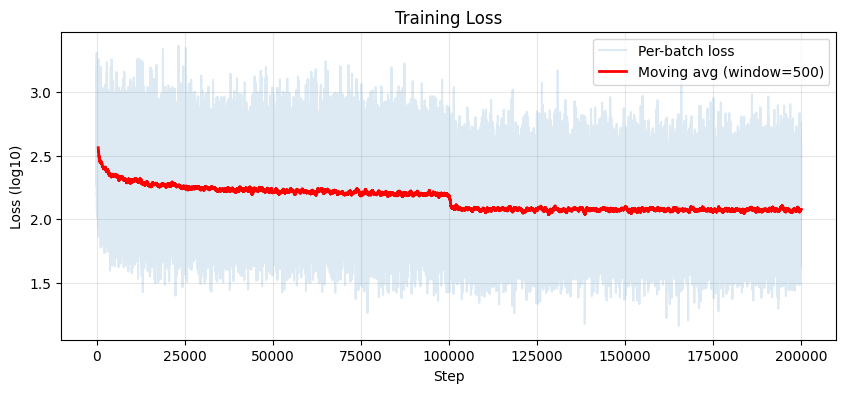

In [21]:
print(f"Final training loss: {lossi[-1]}")
plot_loss(stepi, lossi)

We can see that we are actually not doing much better than before, in fact we are doing **worse**. (For same model, we had training loss of `2.3501` in our previous notebook).

This is because we initialized the weights `W2` to 0, introducing a symmetry and making it much harder for the model to pass gradients through during backprop.

### The symmetry problem with W2 = 0

To understand why zero initialization is so damaging, let's trace exactly what happens during the **first forward and backward pass** when `W2 = 0`.

**Forward pass:**

```
logits = h @ W2 + b2
```

Since `W2 = 0` and `b2 = 0`, all logits are exactly 0 → softmax gives a uniform distribution → loss ≈ 3.296. So far so good — this is the "correct" initial loss.

**Backward pass — the problem emerges:**

The gradient flows backward through the network. Let's follow it:

1. **$\frac{\partial \mathcal{L}}{\partial \text{logits}}$**: This is `softmax(logits) - one_hot(target)`. Since softmax is uniform ($\frac{1}{27}$ for each class), this gradient is a vector that's roughly $\frac{1}{27} \approx 0.037$ everywhere, with $\frac{1}{27} - 1 \approx -0.963$ at the correct class index. This is fine — nonzero gradients.

2. **$\frac{\partial \mathcal{L}}{\partial W_2} = h^T \cdot \frac{\partial \mathcal{L}}{\partial \text{logits}}$**: Since $h$ (the tanh activations) is nonzero and $\frac{\partial \mathcal{L}}{\partial \text{logits}}$ is nonzero, this gradient is nonzero. So `W2` **does** get updated — it will move away from zero after one step. ✓

3. **$\frac{\partial \mathcal{L}}{\partial h} = \frac{\partial \mathcal{L}}{\partial \text{logits}} \cdot W_2^T$**: Here's the critical problem: **$W_2$ is still zero during this backward pass** (parameters are updated _after_ the full backward pass, not during it). So $\frac{\partial \mathcal{L}}{\partial h} = \frac{\partial \mathcal{L}}{\partial \text{logits}} \cdot \mathbf{0}^T = \mathbf{0}$. The gradient signal **dies completely** at this point.

4. **$\frac{\partial \mathcal{L}}{\partial W_1}$**: This depends on $\frac{\partial \mathcal{L}}{\partial h}$ flowing backward through the tanh. But $\frac{\partial \mathcal{L}}{\partial h} = 0$, so $\frac{\partial \mathcal{L}}{\partial W_1} = 0$. The first layer receives **no learning signal whatsoever**.

The result: after the first step, `W2` gets a small update but `W1` stays exactly where it started. On the second step, `W2` is now slightly nonzero, so a tiny gradient trickles back to `W1` — but it's very small. It takes many steps for `W1` to start receiving meaningful gradients, and during all those steps, the network is effectively only learning through its output layer. The hidden layer — which is responsible for learning useful features — is essentially frozen at its random initialization for a long time.

Let's verify this with a tiny example below.


In [33]:
# Worked example: tiny network (2 inputs → 10 hidden → 27 outputs)
# Running for 5 steps to see how gradients evolve over time
# Using a larger output dim and small lr so the effect is clearly visible

torch.manual_seed(0)

x = torch.randn(1, 2)
target = torch.tensor([5])      # correct class is 5 (out of 27)
lr = 0.001
n_hidden_demo = 10
n_out_demo = 27

print("=" * 60)
print("CASE 1: W2 initialized to ZERO")
print("=" * 60)

W1_c1 = torch.randn(2, n_hidden_demo, requires_grad=True)
W2_c1 = torch.zeros(n_hidden_demo, n_out_demo, requires_grad=True)
b2_c1 = torch.zeros(n_out_demo, requires_grad=True)

for step in range(5):
    h = torch.tanh(x @ W1_c1)
    logits = h @ W2_c1 + b2_c1
    loss = F.cross_entropy(logits, target)
    loss.backward()

    w1_grad_norm = W1_c1.grad.norm().item()
    w2_grad_norm = W2_c1.grad.norm().item()
    print(f"  Step {step}: loss={loss.item():.4f}  "
          f"||∂L/∂W1||={w1_grad_norm:.6f}  "
          f"||∂L/∂W2||={w2_grad_norm:.6f}")

    with torch.no_grad():
        W1_c1 -= lr * W1_c1.grad
        W2_c1 -= lr * W2_c1.grad
        b2_c1 -= lr * b2_c1.grad
    W1_c1.grad = None
    W2_c1.grad = None
    b2_c1.grad = None

print(f"\n{'=' * 60}")
print("CASE 2: W2 initialized to SMALL values (0.01)")
print("=" * 60)

torch.manual_seed(0)  # reset so W1 starts the same

W1_c2 = torch.randn(2, n_hidden_demo, requires_grad=True)
W2_c2 = (torch.randn(n_hidden_demo, n_out_demo) * 0.01).requires_grad_(True)
b2_c2 = torch.zeros(n_out_demo, requires_grad=True)

for step in range(5):

    h = torch.tanh(x @ W1_c2)
    logits = h @ W2_c2 + b2_c2
    loss = F.cross_entropy(logits, target)
    loss.backward()

    w1_grad_norm = W1_c2.grad.norm().item()
    w2_grad_norm = W2_c2.grad.norm().item()
    print(f"  Step {step}: loss={loss.item():.4f}  "
          f"||∂L/∂W1||={w1_grad_norm:.6f}  "
          f"||∂L/∂W2||={w2_grad_norm:.6f}")

    with torch.no_grad():
        W1_c2 -= lr * W1_c2.grad
        W2_c2 -= lr * W2_c2.grad
        b2_c2 -= lr * b2_c2.grad
    W1_c2.grad = None
    W2_c2.grad = None
    b2_c2.grad = None

CASE 1: W2 initialized to ZERO
  Step 0: loss=3.2958  ||∂L/∂W1||=0.000000  ||∂L/∂W2||=2.240870
  Step 1: loss=3.2899  ||∂L/∂W1||=0.001189  ||∂L/∂W2||=2.240353
  Step 2: loss=3.2839  ||∂L/∂W1||=0.002377  ||∂L/∂W2||=2.239833
  Step 3: loss=3.2779  ||∂L/∂W1||=0.003564  ||∂L/∂W2||=2.239311
  Step 4: loss=3.2719  ||∂L/∂W1||=0.004751  ||∂L/∂W2||=2.238787

CASE 2: W2 initialized to SMALL values (0.01)
  Step 0: loss=3.2722  ||∂L/∂W1||=0.023409  ||∂L/∂W2||=2.343961
  Step 1: loss=3.2657  ||∂L/∂W1||=0.023463  ||∂L/∂W2||=2.343363
  Step 2: loss=3.2593  ||∂L/∂W1||=0.023574  ||∂L/∂W2||=2.342761
  Step 3: loss=3.2528  ||∂L/∂W1||=0.023741  ||∂L/∂W2||=2.342157
  Step 4: loss=3.2464  ||∂L/∂W1||=0.023962  ||∂L/∂W2||=2.341550


The example confirms exactly what we predicted:

- **Case 1 ($W_2 = 0$):** At step 0, $\left\|\frac{\partial \mathcal{L}}{\partial W_1}\right\|$ is exactly 0 — the hidden layer is completely frozen. After step 0 updates $W_2$ to something slightly nonzero, a tiny gradient starts trickling back to $W_1$ in subsequent steps, but it's orders of magnitude smaller than in Case 2. The hidden layer is learning, but _agonizingly slowly_.
- **Case 2 ($W_2 = 0.01 \times \text{random}$):** $\left\|\frac{\partial \mathcal{L}}{\partial W_1}\right\|$ is nonzero from step 0. Both layers learn immediately.

The key formula to remember: $\frac{\partial \mathcal{L}}{\partial h} = \frac{\partial \mathcal{L}}{\partial \text{logits}} \cdot W_2^T$. If $W_2 = 0$, then $W_2^T = 0$, and the entire backward signal is multiplied by zero — killing all gradients to earlier layers.

So, instead of setting `W2` to `0`, lets scale it by `0.01` — small enough that logits start near zero, but nonzero so gradients can flow.


In [ ]:
# lets now train this network for the entire 200k steps
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                        generator=g)
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2 # seto to 0
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2 # set to 0
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w2 = 0.01, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters])
print(f"Final training loss: {lossi[-1]}")

Training: 100%|██████████| 200000/200000 [01:14<00:00, 2693.85it/s, loss=2.2992]


Final training loss: 1.942139744758606


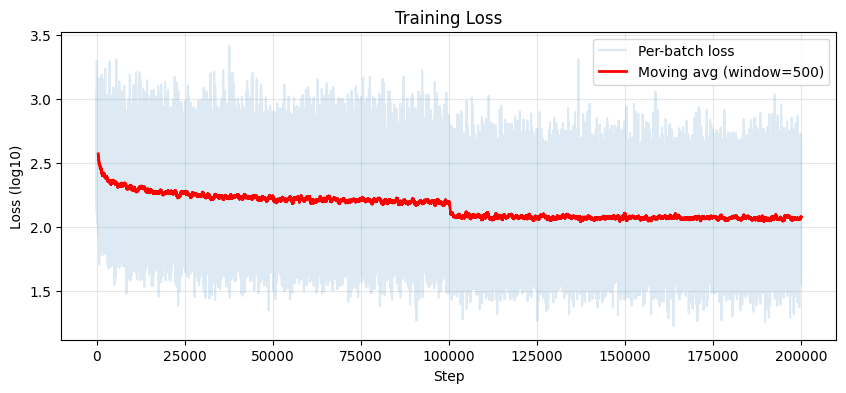

In [23]:
plot_loss(stepi, lossi)

We can see that by properly initializing the weight `W2` and the bias `b2`, we are getting much better results with training loss of `1.9`. Another thing to note here is that our loss is no longer extremely hockey-stick shaped like before. This is because in the badly initialized network, the model spent the first few thousand steps just trying to squish the weights, as opposed to doing any actual learning. When we properly initialized the network, the model was already starting to learn within the initial steps.

**The hockey-stick problem:** With random initialization, the initial loss was ~24 (vs the expected ~3.3). Those first thousands of steps aren't really "learning" the structure of names — they're just fighting to bring the output distribution from wildly overconfident back down to something reasonable. This is wasted optimization budget. By initializing `W2` small, we skip that entire phase and the network immediately begins learning useful patterns.

**A general principle:** For the final (output) layer of a classification network, it's common practice to initialize the weights very small (or zero for biases) so that the initial predictions are approximately uniform. PyTorch's default `nn.Linear` initialization already does something similar — it draws from $\mathcal{U}(-\frac{1}{\sqrt{d}}, \frac{1}{\sqrt{d}})$ where $d$ is the fan-in, which keeps initial outputs small.

Are we done though? _Not really_. We've fixed the output layer, but we haven't looked at what's happening _inside_ the network. Next lets take a look at the activations after the non-linearity from our first linear layer — the `tanh` outputs. If those are problematic, we'll have another issue to address.


In [35]:
# lets now train this network for the entire 200k steps
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                        generator=g)
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w2 = 0.01, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters], n_steps=1)
print(f"Final training loss: {lossi[-1]}")

Training: 100%|██████████| 1/1 [00:00<00:00, 387.89it/s, loss=3.3087]

Final training loss: 3.3087048530578613


## Section 1.2: Hidden layer activations — the tanh saturation problem

We've fixed the output layer so the initial loss is reasonable. But what about the _inside_ of the network? Let's inspect the activations coming out of the hidden layer's `tanh` nonlinearity:

```python
hidden_layer_preactivation = emb_cat @ W1 + b1
h = torch.tanh(hidden_layer_preactivation)
```

Remember, `tanh` squashes its input to the range $[-1, 1]$. If the pre-activation values going _into_ `tanh` are very large (positive or negative), the outputs will be pushed to the extreme ends of this range — we call this **saturation**. Let's see if that's happening.


In [36]:
h.shape

torch.Size([32, 200])

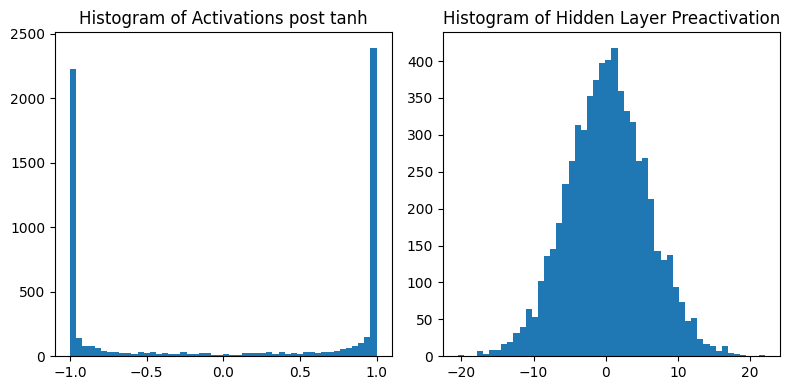

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(h.flatten().tolist(), bins=50)
axs[0].set_title('Histogram of Activations post tanh')

axs[1].hist(hidden_layer_preactivation.flatten().tolist(), bins=50)
axs[1].set_title('Histogram of Hidden Layer Preactivation')

plt.tight_layout()
plt.show()

### Why tanh saturation kills gradients

The histogram on the left shows that almost all activations are pinned at exactly -1 or +1. The histogram on the right reveals why: the pre-activation values (`emb_cat @ W1 + b1`) span a huge range (roughly -15 to +15), so `tanh` is operating deep in its flat tails.

Why is this a problem? Recall the backward pass through `tanh` from our [micrograd notebook](../lesson_1_micrograd/micrograd.ipynb):

```python
def tanh(self):
    x = self.data
    tanh_val = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(tanh_val, (self, ), 'tanh')

    def backward():
        self.grad += (1 - tanh_val**2) * out.grad

    out._backward = backward
    return out
```

The local gradient of `tanh` is $(1 - \tanh^2(x))$. Consider two cases:

1. **`tanh(x) ≈ 0`** (pre-activation near 0): The local gradient is $(1 - 0^2) = 1$. The `tanh` node acts as a **pass-through** — gradients flow through undiminished.
2. **`tanh(x) ≈ ±1`** (pre-activation far from 0 — our situation): The local gradient is $(1 - 1^2) = 0$. The `tanh` node becomes a **gradient killer** — it multiplies the incoming gradient by ~0, blocking all signal from flowing backward.

This is the **vanishing gradient problem** in action. When neurons are saturated, they become **dead neurons** — they can't learn because no gradient flows through them. This makes intuitive sense too: `tanh` is a squashing function, so for any very large input, small changes to that input still get squashed to the same ±1 output, meaning the derivative is near zero.

Note that this problem isn't unique to `tanh` — **sigmoid** has the same flat-tail issue, and **ReLU** has a related problem where negative inputs produce exactly zero gradient (the "dying ReLU" problem).

In our case, we were still able to train the model because `tanh` doesn't saturate for _all_ training examples. For some examples, the pre-activations happen to be near zero, allowing gradients to pass through — but this is wasteful. We can see this in the next cell.


torch.Size([32, 200])


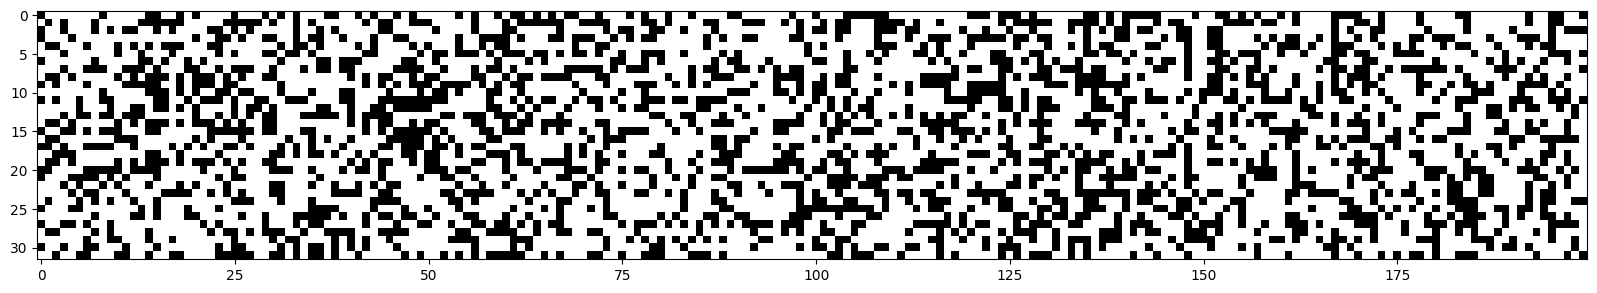

In [49]:
print(h.shape)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In the above plot, the white cells denote where tanh is saturated (not allowing gradients), while black shows where it isn't. The rows are the 32 examples in our mini-batch; the columns are the 200 neurons. We can see that no column is entirely white, which means every neuron is activated (non-saturated) for _at least some_ inputs — so no neuron is truly "dead." But the vast majority of cells are white, meaning most neurons are saturated for most inputs, which is still very wasteful.

**Dead neurons during training:** Even with perfect initialization, dead neurons can appear _during_ training. If the learning rate is too high, a large gradient update can push a neuron's weights so far that it falls off the data manifold — from that point on, no input example will ever activate it, and it's permanently dead. This is one reason why learning rate tuning matters.

### How do we fix this?

The same way we fixed the logits — by controlling the scale of the pre-activations.

```python
hidden_layer_preactivation = emb_cat @ W1 + b1
h = torch.tanh(hidden_layer_preactivation)
```

If we want `h` to take on a range of values (not just ±1), we need `hidden_layer_preactivation` to be near 0 at initialization — in the linear region of `tanh` where it hasn't saturated yet. We can achieve this by scaling down `W1` and `b1`, just like we did for `W2` and `b2` with the logits.


In [50]:
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w1 = 0, scale_b1 = 0, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g) * scale_w1
    b1 = torch.randn(n_hidden,                        generator=g) * scale_b1
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w1 = 0.2, scale_b1 = 0.01, scale_w2 = 0.01, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters], n_steps=1)
print(f"Final training loss: {lossi[-1]}")

Training: 100%|██████████| 1/1 [00:00<00:00, 511.75it/s, loss=3.3103]

Final training loss: 3.310317039489746


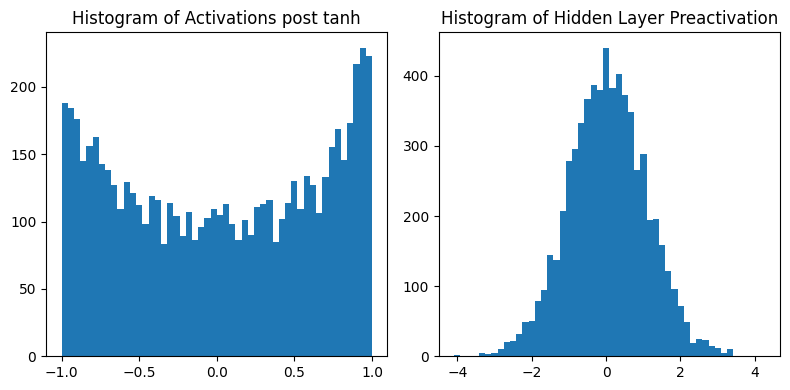

In [51]:
# lets look at our tanh activations now
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(h.flatten().tolist(), bins=50)
axs[0].set_title('Histogram of Activations post tanh')

axs[1].hist(hidden_layer_preactivation.flatten().tolist(), bins=50)
axs[1].set_title('Histogram of Hidden Layer Preactivation')

plt.tight_layout()
plt.show()

torch.Size([32, 200])


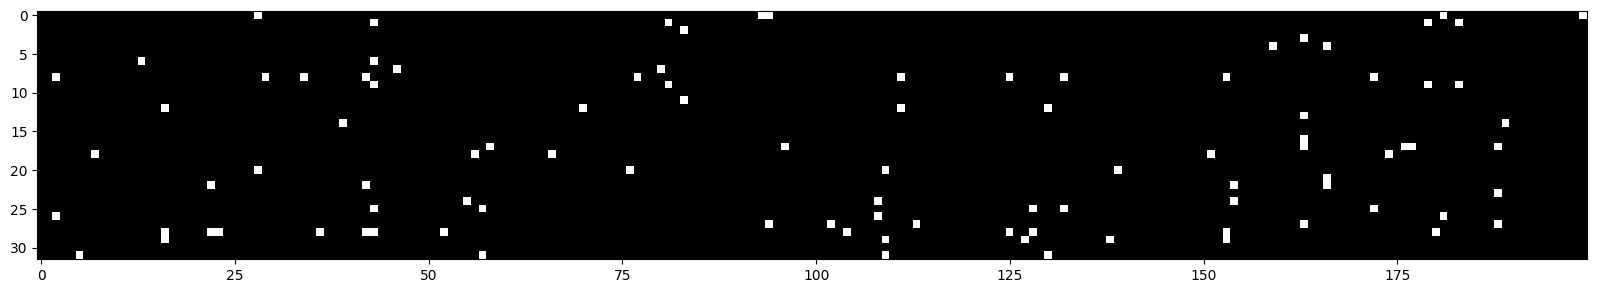

In [52]:
print(h.shape)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Now we can see that our tanh activations follow a much better distribution — a nice spread between -1 and +1 with most values in the interior, and the saturation plot is almost entirely black (no saturated neurons). Gradients can now flow freely through the hidden layer from the very first step.

Let's train the model for the full 200k steps and see if this translates to better final performance.


In [53]:
embed_dim = 10
block_size = 3
n_hidden = 200

def get_params(embed_dim, block_size, n_hidden, scale_w1 = 0, scale_b1 = 0, scale_w2 = 0, scale_b2 = 0):
    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g) * scale_w1
    b1 = torch.randn(n_hidden,                        generator=g) * scale_b1
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * scale_w2
    b2 = torch.randn(vocab_size,                       generator=g) * scale_b2
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return C, W1, b1, W2, b2, parameters

C, W1, b1, W2, b2, parameters = get_params(embed_dim, block_size, n_hidden, scale_w1 = 0.2, scale_b1 = 0.01, scale_w2 = 0.01, scale_b2 = 0)

stepi, lossi, loglossi, hidden_layer_preactivation, h, logits = train_model([C, W1, b1, W2, b2, parameters])
print(f"Final training loss: {lossi[-1]}")

Training: 100%|██████████| 200000/200000 [01:15<00:00, 2635.30it/s, loss=1.9604]

Final training loss: 1.8663502931594849


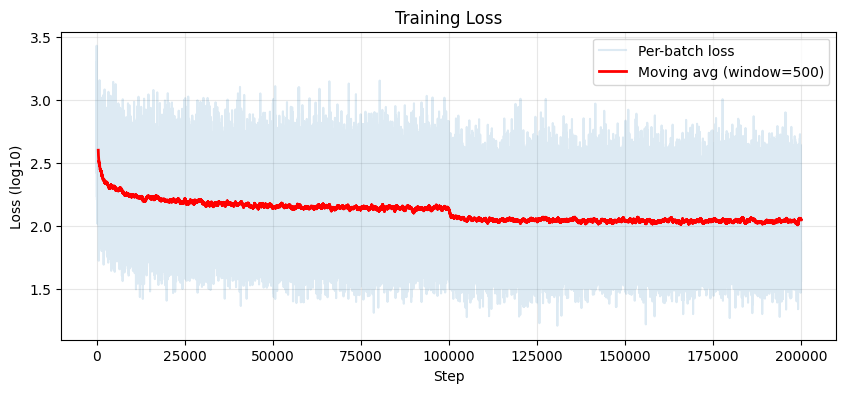

In [54]:
plot_loss(stepi, lossi)

### The problem with hand-tuned initialization

This illustrates the impact of initialization on training — by carefully choosing scale factors for `W1`, `b1`, `W2`, and `b2`, we got the initial loss right, avoided tanh saturation, and achieved reasonable training loss.

But we picked those scale factors (`0.2`, `0.01`, etc.) **by hand**, through trial and error. This approach doesn't scale:

- Different architectures need different scales
- Adding or removing layers changes what works
- Changing the hidden size, embedding size, or any other hyperparameter invalidates the previous tuning

We need a **principled, automatic** way to choose initialization scales based on the network architecture. This is exactly what **Kaiming (He) initialization** provides — a formula derived from the statistics of the forward pass that tells us the right scale for each layer based on its fan-in. We'll cover that next.
